# Import data

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import plotly.express as px
import lime
import lime.lime_tabular
from quantile_forest import RandomForestQuantileRegressor
from sklearn.linear_model import ElasticNet
import lowess

df_nan = pd.read_csv('final_data_files/1_df_nan.csv', sep=',', index_col=0)
df_man = pd.read_csv('final_data_files/2_df_man.csv', sep=',', index_col=0)
df_noNanCat = pd.read_csv('final_data_files/7_df_freq_noNanCat.csv', sep=',', index_col=0)
randomSeed = 100
pd.set_option('display.max_columns', None)

characterization of imgae variables

         image land   image water  image brightness    land_water
count  13603.000000  13603.000000      13603.000000  13603.000000
mean       0.455267      0.840256        124.967561      1.295523
std        0.498013      0.366382         25.395378      0.460624
min        0.000000      0.000000         15.243877      0.000000
25%        0.000000      1.000000        109.789651      1.000000
50%        0.000000      1.000000        122.258919      1.000000
75%        1.000000      1.000000        136.547473      2.000000
max        1.000000      1.000000        244.112094      2.000000
                  image land  image water  image brightness  land_water
image land          1.000000    -0.466063         -0.006595    0.710463
image water        -0.466063     1.000000         -0.012601    0.291510
image brightness   -0.006595    -0.012601          1.000000   -0.017154
land_water          0.710463     0.291510         -0.017154    1.000000


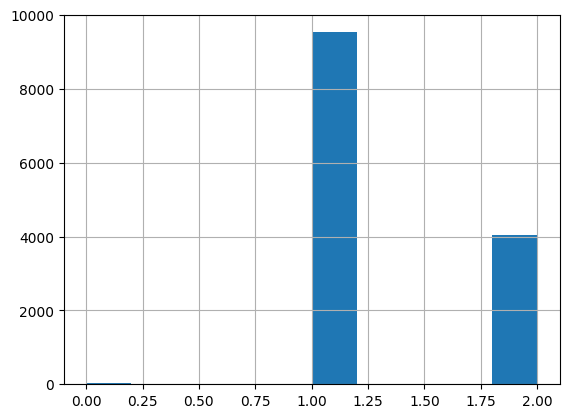

In [7]:
df_temp = df_noNanCat[['image land', 'image water', 'image brightness']].copy()
df_temp['land_water'] = df_temp['image land'] + df_temp['image water']
print(df_temp.describe())
print(df_temp.corr())
#histogram of land_water
df_temp['land_water'].hist()
plt.show()


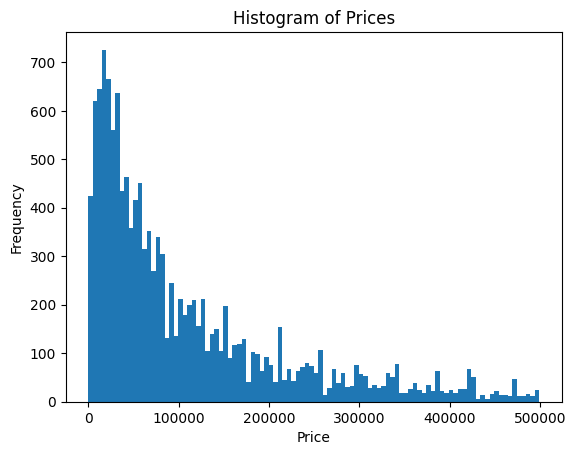

In [2]:
#histogram of prices in df_nan
plt.hist(df_nan['Price'], bins=100)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices')
plt.show()

# Train model (XGBoost and Quantile Regression Forest)

In [30]:
boats_df = df_noNanCat.copy()

In [ ]:
# Define Features and Target
X = boats_df.drop(['Price'], axis=1)
y = boats_df['Price']

# Split the dataset into training and testing sets (NOTE! the random seed NEEDS to be the same here as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= randomSeed)

# Determine weights
threshold = np.quantile(y_train, 0.7)
weights = np.where(y_train > threshold, 2.0, 1.0)

# Define the model
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.85, learning_rate = 0.096,
                              max_depth = 8, alpha = 8.31, n_estimators = 164)
model_QRF = RandomForestQuantileRegressor()

# Train the model
model.fit(X_train, y_train, sample_weight=weights)
#model.fit(X_train, y_train)
model_QRF.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
predictions_QRF = model_QRF.predict(X_test, quantiles=[0.025, 0.5, 0.975])

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

# Plot Actual vs. Predicted

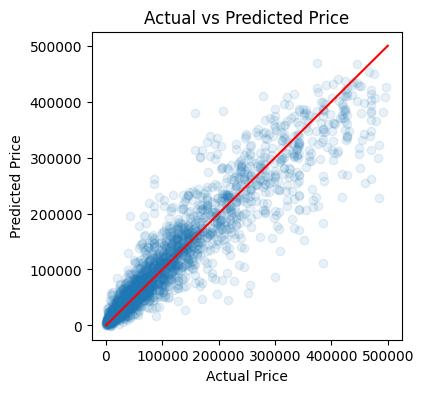

In [5]:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([0, 500000], [0, 500000], color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.savefig('imagesInterpretation/actual_vs_predicted_price.png')
plt.show()


# Variable importance

In [6]:
#calculate permutation feature importance of the model
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)


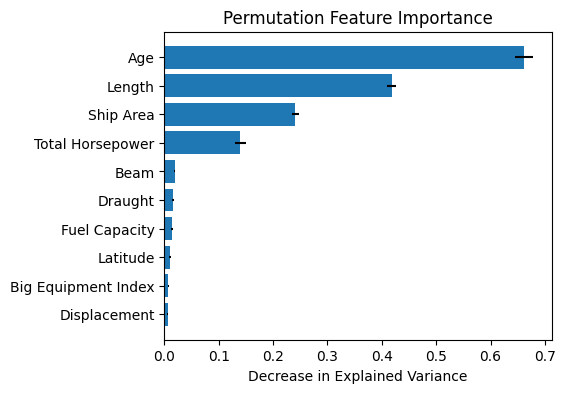

<Figure size 640x480 with 0 Axes>

In [7]:
# plot the permutation feature importance for the 10 most important features
sorted_idx = perm_importance.importances_mean.argsort()
sorted_idx = sorted_idx[-10:]
plt.figure(figsize=(5, 4))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], xerr=perm_importance.importances_std[sorted_idx])
plt.xlabel("Decrease in Explained Variance")
plt.title('Permutation Feature Importance')
plt.show()
plt.savefig('imagesInterpretation/permutation_feature_importance.png')

### Partial Dependence Plots (PDPs) for the most important features

In [10]:
common_params = {
    "subsample": 400,
    "grid_resolution": 100,
    "random_state": randomSeed,
}
common_params2 = {
    "subsample": 10000,
    "grid_resolution": 2000,
    "random_state": 1,
}
common_params3 = {
    "subsample": 800,
    "grid_resolution": 20,
    "random_state": randomSeed,
}

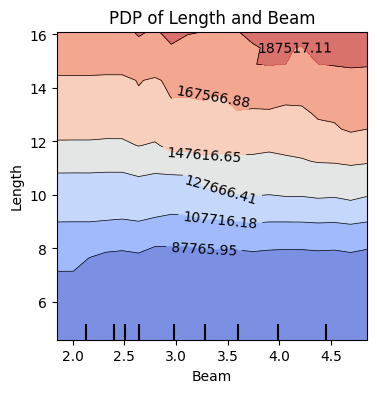

In [28]:
features_info = {
    'features': [("Beam", "Length")],
    'kind': 'average',
    #'categorical_features': ["Sailing Vessel", "Motorized Vessel"]
}
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("PDP of Length and Beam")
display = PartialDependenceDisplay.from_estimator(model, X, **features_info, **common_params3, ax=ax, contour_kw={"cmap": "coolwarm"})

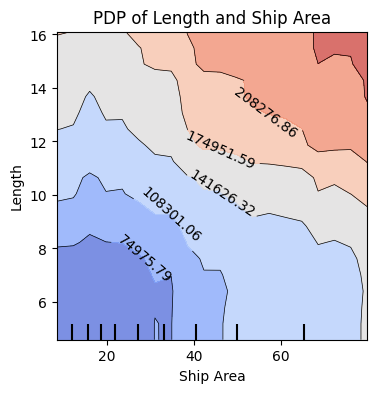

In [27]:
features_info = {
    'features': [("Ship Area", "Length")],
    'kind': 'average',
    #'categorical_features': ["Sailing Vessel", "Motorized Vessel"]
}
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("PDP of Length and Ship Area")
display = PartialDependenceDisplay.from_estimator(model, X, **features_info, **common_params3, ax=ax, contour_kw={"cmap": "coolwarm"})
#save the plot
plt.savefig('imagesInterpretation/pdp_area_length.png')

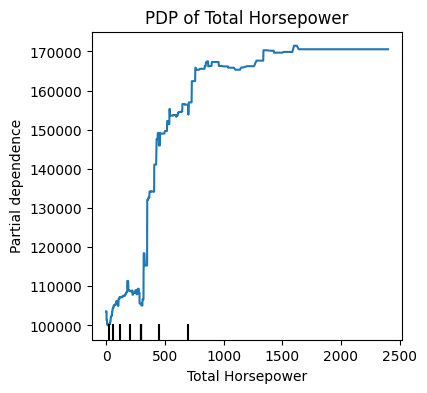

In [26]:
features_info = {
    'features': ["Total Horsepower"],
    'kind': 'average',
    #'categorical_features': ["image land", "image water"]
}
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("PDP of Total Horsepower")
display = PartialDependenceDisplay.from_estimator(model, X, **features_info, **common_params2, ax=ax)

### Individual Conditional Expectation (ICE) plot

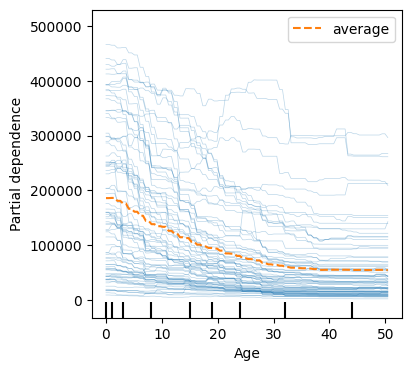

In [308]:
common_params_ice = {
    "subsample": 80,
    "grid_resolution": 100,
    "random_state": randomSeed,
}

features_info = {
    'features': ["Age"],
    'kind': 'both',
    #'categorical_features': ["Condition"]
}
fig, ax = plt.subplots(figsize=(4, 4))
display = PartialDependenceDisplay.from_estimator(model, X, **features_info, **common_params_ice, ax=ax)
plt.savefig('imagesInterpretation/pdp_age.png')

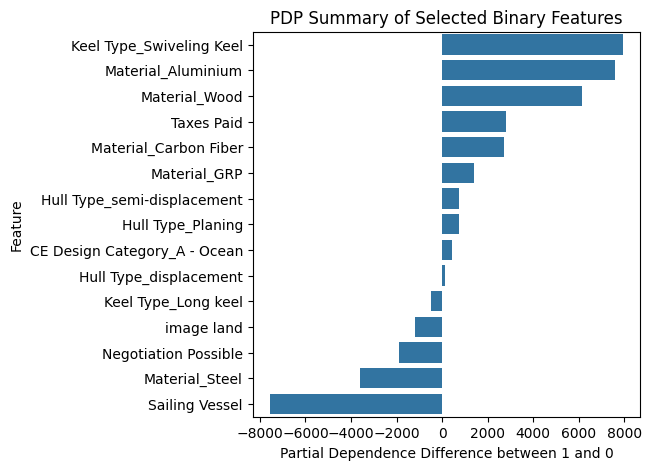

<Figure size 640x480 with 0 Axes>

In [300]:
#calculate partial_dependence() scores for each of the following variables
binary_features = ["Sailing Vessel", "Material_Wood", "Keel Type_Swiveling Keel", "Material_Steel", 
                   "Negotiation Possible", "Material_Aluminium", "CE Design Category_A - Ocean", "Taxes Paid", "Material_Carbon Fiber", 
                   "Material_GRP", "Keel Type_Long keel", "Hull Type_Planing", "Hull Type_semi-displacement", 
                   "Hull Type_displacement", "image land"]
binary_pdp_scores = []
for feature in binary_features:
    pdp1 = partial_dependence(model, X, features=[X.columns.get_loc(feature)], 
                          categorical_features=[X.columns.get_loc(feature)], kind='average')
    pdp_diff = pdp1['average'][0][1] - pdp1['average'][0][0]
    binary_pdp_scores.append(pdp_diff)
#merge binary_features and binary_pdp_scores into dataframe and plot
binary_pdp_df = pd.DataFrame({'Feature': binary_features, 'PDP Score': binary_pdp_scores})
binary_pdp_df = binary_pdp_df.sort_values(by='PDP Score', ascending=False)
plt.figure(figsize=(5, 5))
sns.barplot(x='PDP Score', y='Feature', data=binary_pdp_df)
plt.xlabel('Partial Dependence Difference between 1 and 0')
plt.title('PDP Summary of Selected Binary Features')
plt.show()
plt.savefig('imagesInterpretation/pdp_summary_binary_features.png')
# plot shows change in partial dependence score for each feature going from 0 to 1


# LIME

In [32]:
train = X_train.to_numpy()
test = X_test.to_numpy()

categorical_features = np.argwhere(np.array([len(set(train[:,x])) for x in range(train.shape[1])]) <= 2).flatten()
feature_names = X_train.columns
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names= feature_names, class_names=['Price'], 
                                                   categorical_features=categorical_features, verbose = True, 
                                                   mode='regression', random_state = randomSeed, 
                                                   discretize_continuous=False)


In [37]:
#Choose an observation in your training set
explain_observations = []
intercepts = []
black_box_prediction = model.predict(X_test)
local_prediction = []
r_2 = []
for i in range(len(test[:,1])):
    exp = explainer.explain_instance(test[i], model.predict, model_regressor=ElasticNet())#, num_features=10)
    intercepts.append(exp.intercept[0])
    #Line below prints graphs -> do not run in for loop
    #exp.show_in_notebook(show_table=True)
    explain_observations.append(exp.as_list())
    local_prediction.append(exp.local_pred[0])
    r_2.append(exp.score)


Intercept 133882.98455646622
Prediction_local [129388.52892833]
Right: 45576.207
Intercept 134920.80668368025
Prediction_local [147956.0965922]
Right: 194681.19
Intercept 134021.11082063624
Prediction_local [113085.49989402]
Right: 45432.625
Intercept 133781.38438571105
Prediction_local [198382.65047671]
Right: 258158.44
Intercept 134132.1561353045
Prediction_local [76043.30291906]
Right: 7579.5747
Intercept 137373.36565372
Prediction_local [164785.17234956]
Right: 180633.66
Intercept 133295.64546113968
Prediction_local [177258.66282897]
Right: 174220.16
Intercept 132316.5516311319
Prediction_local [133472.76438057]
Right: 42935.395
Intercept 135177.8631885789
Prediction_local [164677.63186662]
Right: 155982.48
Intercept 136773.3619270746
Prediction_local [130168.9773227]
Right: 16819.66
Intercept 134216.50268097088
Prediction_local [92020.0250759]
Right: 290102.28
Intercept 134813.8992975767
Prediction_local [128223.33679408]
Right: 51037.332
Intercept 133445.16340595548
Prediction_lo

In [41]:
# Finds all points for a single variable
def one_variable_LIME (name, predictions, explained):
    index = []
    predictions_used = []
    contained_used = []
    for i in range(len(explained)):
        observation = explained[i]
        for element in observation:
            #Removes observations with r2 below 0.3
            if element[0] == name and r_2[i] >= 0.3:
                predictions_used.append(predictions[i])
                index.append(i)
                contained_used.append(element[1])
    data = pd.DataFrame({'index': index, 'prediction': predictions_used, name: contained_used})
    return data

In [74]:
def plot_one_variable_LIME (name):
    scores = one_variable_LIME(name, black_box_prediction, explain_observations)
    print(len(scores))
    scores = scores.sort_values(by='prediction')
    scores = scores.reset_index(drop=True)
    x = scores['prediction']
    y = scores[name]
    z = lowess.lowess(x, y, polynomialDegree=1, bandwidth=0.6)
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, s=3, alpha=0.5)
    plt.plot(x, z, color='red')
    plt.xlabel('Predicted Price')
    plt.ylabel(f'Local Effect of {name}')
    plt.title(f'LIME of {name} for Different Prices')
    plt.show()
    plt.savefig(f'imagesInterpretation/{name}_LIME.png')

In [75]:
def plot_three_variable_LIME (name1, name2, name3):
    scores1 = one_variable_LIME(name1, black_box_prediction, explain_observations)
    scores2 = one_variable_LIME(name2, black_box_prediction, explain_observations)
    scores3 = one_variable_LIME(name3, black_box_prediction, explain_observations)
    print(len(scores1))
    print(len(scores2))
    print(len(scores3))
    scores1 = scores1.sort_values(by='prediction')
    scores1 = scores1.reset_index(drop=True)
    scores2 = scores2.sort_values(by='prediction')
    scores2 = scores2.reset_index(drop=True)
    scores3 = scores3.sort_values(by='prediction')
    scores3 = scores3.reset_index(drop=True)
    x1 = scores1['prediction']
    y1 = scores1[name1]
    x2 = scores2['prediction']
    y2 = scores2[name2]
    x3 = scores3['prediction']
    y3 = scores3[name3]

    #z = lowess.lowess(x, y, polynomialDegree=1, bandwidth=0.4)
    plt.figure(figsize=(8, 5))
    plt.scatter(x1, y1, s=8, alpha=0.5, color='red')
    plt.scatter(x2, y2, s=8, alpha=0.5, color='blue')
    plt.scatter(x3, y3, s=8, alpha=0.5, color='green')
    #add legend
    plt.legend([name1, name2, name3])
    #plt.plot(x, z, color='red')
    plt.xlabel('Predicted Price')
    plt.ylabel(f'Local Price Effect')
    plt.title(f'LIME of Latitude, Draught and Fuel Capacity for Different Prices')
    plt.show()
    #plt.savefig(f'imagesInterpretation/{name1}_LIME.png')

In [ ]:
plot_one_variable_LIME('Total Horsepower')
plot_three_variable_LIME('Latitude', 'Draught', 'Fuel Capacity')

# Use dataset with categorical variables for additional heatmaps

In [38]:
# get all columns that start with "CE Design Category" 
ceDesignColumns = [col for col in df_man if col.startswith('CE Design Category')]
df_man_cats = pd.concat([df_man, pd.from_dummies(df_man[ceDesignColumns], "_")], axis=1)
df_man_cats = df_man_cats.drop(ceDesignColumns, axis=1)

# get all columns that start with "Hull Type"
hullTypeColumns = [col for col in df_man_cats if col.startswith('Hull Type')]
df_man_cats = pd.concat([df_man_cats, pd.from_dummies(df_man_cats[hullTypeColumns], "_")], axis=1)
df_man_cats = df_man_cats.drop(hullTypeColumns, axis=1)

# get all columns that start with "Material"
materialColumns = [col for col in df_man_cats if col.startswith('Material')]
df_man_cats = pd.concat([df_man_cats, pd.from_dummies(df_man_cats[materialColumns], "_")], axis=1)
df_man_cats = df_man_cats.drop(materialColumns, axis=1)

# get all columns that start with "Steering"
steeringColumns = [col for col in df_man_cats if col.startswith('Steering')]
df_man_cats = pd.concat([df_man_cats, pd.from_dummies(df_man_cats[steeringColumns], "_")], axis=1)
df_man_cats = df_man_cats.drop(steeringColumns, axis=1)

# get all columns that start with "Keel Type"
keelTypeColumns = [col for col in df_man_cats if col.startswith('Keel Type')]
df_man_cats = pd.concat([df_man_cats, pd.from_dummies(df_man_cats[keelTypeColumns], "_")], axis=1)
df_man_cats = df_man_cats.drop(keelTypeColumns, axis=1)

df_man_cats[["CE Design Category", "Hull Type", "Material", "Steering", "Keel Type"]] = df_man_cats[["CE Design Category", "Hull Type", "Material", "Steering", "Keel Type"]].astype('category')

In [39]:
# Define Features and Target
X_man_cats = df_man_cats.drop(['Price'], axis=1)
y_man_cats = df_man_cats['Price']

# Split the dataset into training and testing sets (NOTE! the random seed NEEDS to be the same here as before)
X_man_cats_train, X_man_cats_test, y_man_cats_train, y_man_cats_test = train_test_split(X_man_cats, y_man_cats, test_size=0.2, random_state= randomSeed)

# Determine weights
threshold_mc = np.quantile(y_man_cats_train, 0.7)
weights_mc = np.where(y_man_cats_train > threshold_mc, 2.0, 1.0)

# Define the model
model_man_cats = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.85, learning_rate = 0.096,
                              max_depth = 8, alpha = 8.31, n_estimators = 164, enable_categorical=True)

# Train the model
model_man_cats.fit(X_man_cats_train, y_man_cats_train, sample_weight=weights_mc)
#model.fit(X_train, y_train)

# Make predictions
y_mc_pred = model_man_cats.predict(X_man_cats_test)

# Calculate the mean squared error
mse_mc = mean_squared_error(y_man_cats_test, y_mc_pred)
rmse_mc = np.sqrt(mse_mc)

print(f"RMSE: {rmse_mc}")

RMSE: 37516.05972815888


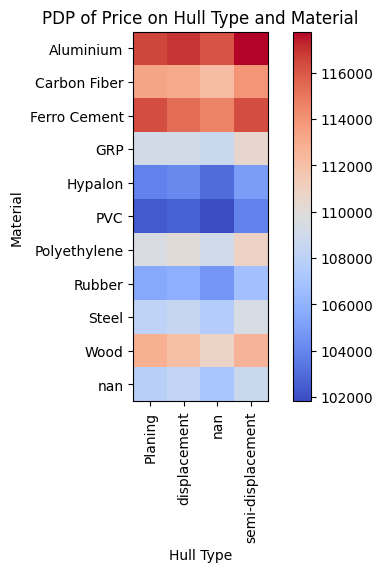

<Figure size 640x480 with 0 Axes>

In [320]:
pdp1 = partial_dependence(model_man_cats, X_man_cats, features=[(35, 36)], kind='average', percentiles=(0.01,0.99),grid_resolution=15)
y_pred1 = np.transpose(pdp1['average'][0])
grid1 = pdp1['grid_values']

plt.imshow(np.transpose(pdp1['average'][0]), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.yticks(range(len(grid1[1])), grid1[1])
plt.xticks(range(len(grid1[0])), grid1[0], rotation=90)
plt.xlabel('Hull Type')
plt.ylabel('Material')
plt.title('PDP of Price on Hull Type and Material')
plt.show()
plt.savefig('imagesInterpretation/pdp_hull_type_material.png')

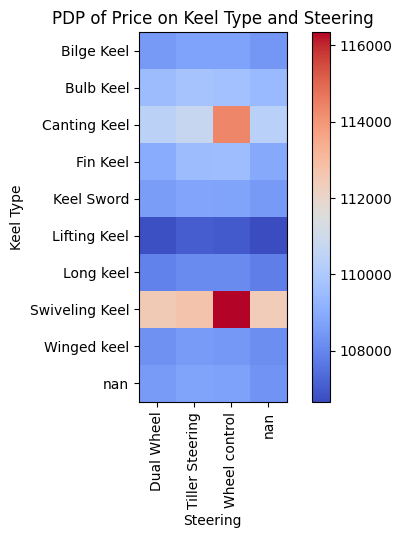

<Figure size 640x480 with 0 Axes>

In [319]:
pdp1 = partial_dependence(model_man_cats, X_man_cats, features=[(37, 38)], kind='average', percentiles=(0.01,0.99),grid_resolution=15)
y_pred1 = np.transpose(pdp1['average'][0])
grid1 = pdp1['grid_values']

plt.imshow(np.transpose(pdp1['average'][0]), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.yticks(range(len(grid1[1])), grid1[1])
plt.xticks(range(len(grid1[0])), grid1[0], rotation=90)
plt.xlabel('Steering')
plt.ylabel('Keel Type')
plt.title('PDP of Price on Keel Type and Steering')
plt.show()
plt.savefig('imagesInterpretation/pdp_keel_type.png')

# Plot price heterogeneity on World Map

In [15]:
#calculate the average price for each pair of coordinates
#convert latitude column to string
df_map = df_nan.copy()
df_map['Latitude'] = df_nan['Latitude'].astype(str)
df_map['Longitude'] = df_nan['Longitude'].astype(str)

#group by coordinates and calculate the average price and the number of observations
df_map = df_map.groupby(['Latitude', 'Longitude'])['Price'].agg(['median', 'count']).reset_index()
#filter out coordinates with less than 5 observations
df_map = df_map[df_map['median'] < 150000]
df_map["count"] = df_map['count'] * 1000

#rename column median as Price
df_map = df_map.rename(columns={'median': 'Median Price'})

df_map['Latitude'] = df_map['Latitude'].astype(float)
df_map['Longitude'] = df_map['Longitude'].astype(float)


In [24]:
fig = px.scatter_mapbox(df_map, lat = 'Latitude', lon = 'Longitude', color = 'Median Price', size = 'count',
                        opacity=1,
                        zoom = 6,
                        center = dict(lat=52.5, lon=5.75),
                        mapbox_style = 'open-street-map',
                        color_continuous_scale='icefire',
                        title = 'Median Price of Boats in European Countries',
                        #template = 'plotly_dark'
                        )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'price_map3.png',
    'height': 450,
    'width': 1144,
    'scale':8 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.show(config=config)

# Quantile Regression Forests: Plot interval sizes against price

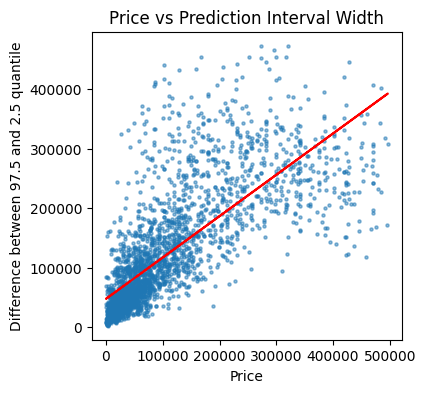

<Figure size 640x480 with 0 Axes>

In [29]:
# for predictionsQRF make a new column that is the difference between the 97.5 and 2.5 quantile
predictions_QRF = pd.DataFrame(predictions_QRF, columns = ['Q025', 'Q50', 'Q975'])
predictions_QRF['diff'] = predictions_QRF.iloc[:,2] - predictions_QRF.iloc[:,0]
predictions_QRF['Price'] = y_test.values

#plot 'diff' against 'Price'
plt.figure(figsize=(4, 4))
plt.scatter(predictions_QRF['Price'], predictions_QRF['diff'], alpha=0.5, s=5)
plt.xlabel('Price')
plt.ylabel('Difference between 97.5 and 2.5 quantile')
plt.title('Price vs Prediction Interval Width')
#add a regression line in the plot
m, b = np.polyfit(predictions_QRF['Price'], predictions_QRF['diff'], 1)
plt.plot(predictions_QRF['Price'], m*predictions_QRF['Price'] + b, color='red')
plt.show()
plt.savefig('imagesInterpretation/QRF_price_vs_diff.png')